# Timestamps Data Analysis

## Load Data 

In [13]:
import pandas as pd
# Step 1: Load Data Directly From FRED
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=IPG2211A2N"
data = pd.read_csv(url)

                  Energy Production
observation_date                   
1939-01-01                   3.3336
1939-02-01                   3.3591
1939-03-01                   3.4354
1939-04-01                   3.4608
1939-05-01                   3.4608


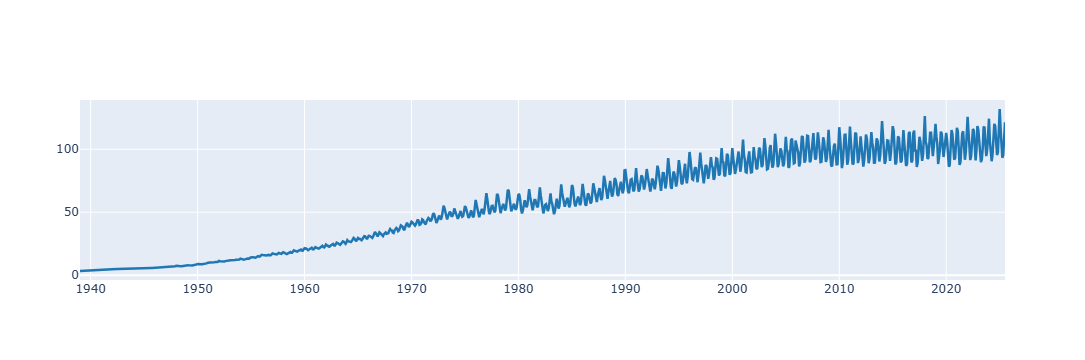

In [14]:
import pandas as pd
import plotly.graph_objects as go  # ✅ IMPORT ESSENTIEL MANQUANT
import warnings

# Supprimer cufflinks et matplotlib pour éviter les conflits
# Nous utilisons uniquement l'API native de Plotly

# Supprimer les avertissements
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Convertir l'index en datetime et le définir comme index
data['observation_date'] = pd.to_datetime(data['observation_date'])
data.set_index('observation_date', inplace=True)

# Renommer la colonne
data.rename(columns={'IPG2211A2N': 'Energy Production'}, inplace=True)

# Afficher les 5 premières valeurs
print(data.head())

# CRÉER LE GRAPHIQUE AVEC L'API NATIVE DE PLOTLY (CORRIGÉ)
fig = go.Figure()  # ✅ CRÉATION DE L'OBJET FIG (MANQUANT DANS VOTRE CODE)

# Ajouter les données au graphique
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['Energy Production'],
    mode='lines',
    name='Energy Production',
    line=dict(color='#1f77b4', width=2.5)
))
# Afficher le graphique
fig.show()

## Decomposition 

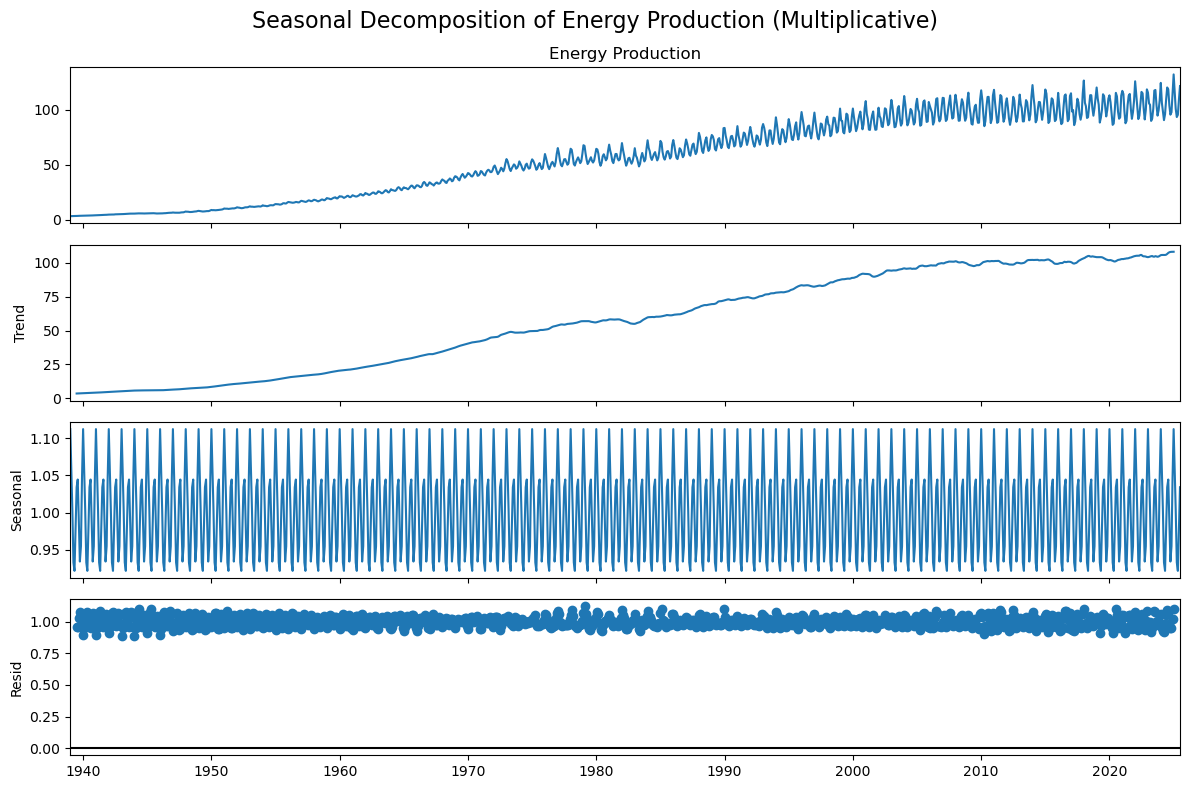

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (must be 1D Series)
result = seasonal_decompose(data['Energy Production'], model='multiplicative', period=12)

# Plot the decomposition
fig = result.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition of Energy Production (Multiplicative)", fontsize=16)
plt.tight_layout()
plt.show()

## Performing the Seasonal ARIMA 

In [16]:
import pandas as pd
import warnings
from pmdarima import auto_arima

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fit auto_arima model
stepwise_model = auto_arima(
    data['Energy Production'],      # Must be a 1D Series
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    m=12,                           # Seasonality = 12 months
    start_P=0,
    seasonal=True,
    d=1, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Print the AIC value (model fit metric)
print("Best AIC value:", stepwise_model.aic())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4276.076, Time=0.81 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4935.789, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4685.361, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4390.083, Time=0.38 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4652.282, Time=0.41 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=4277.302, Time=1.03 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=4276.753, Time=1.73 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=4498.861, Time=0.76 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=4272.510, Time=2.61 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=4230.344, Time=3.61 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=4244.137, Time=1.78 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=4323.434, Time=2.62 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=4405.773, Time=2.99 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=4231.817, Time=4.07 sec
 ARIMA(1,1,2)(2,1,2

## Forecast of Energy Production (Next 36 Months)

In [18]:
pip install plotly==5.13.0

  Using cached plotly-5.13.0-py2.py3-none-any.whl.metadata (7.0 kB)
Using cached plotly-5.13.0-py2.py3-none-any.whl (15.2 MB)
  Attempting uninstall: plotly
    Found existing installation: plotly 6.3.0
    Uninstalling plotly-6.3.0:
      Successfully uninstalled plotly-6.3.0
Note: you may need to restart the kernel to use updated packages.


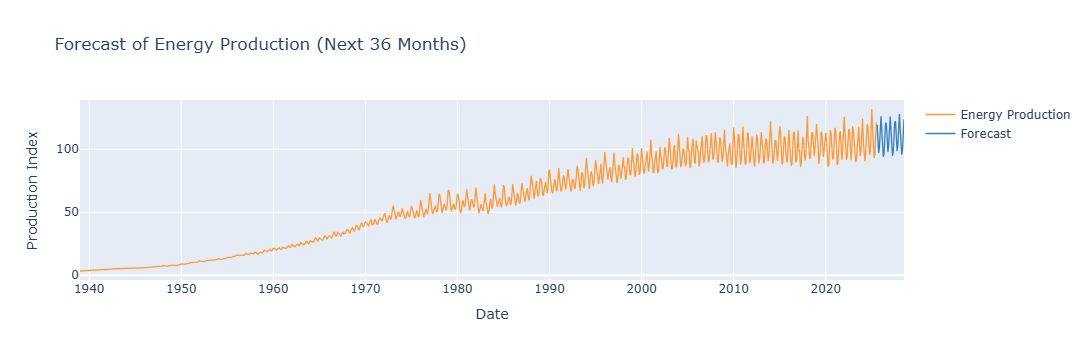

In [22]:
import pandas as pd
import cufflinks as cf
import warnings

warnings.filterwarnings("ignore")

# Ensure index is datetime
#data.index = pd.to_datetime(data.index)

# Forecast
n_periods = 36
future_forecast = stepwise_model.predict(n_periods=n_periods)

# Create forecast index
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1),
                               periods=n_periods, freq='MS')

# Create DataFrame for plotting
forecast_df = pd.DataFrame({'Forecast': future_forecast}, index=forecast_index)

# Combine data
combined = pd.concat([data['Energy Production'], forecast_df], axis=1)

# Use cufflinks with custom layout to avoid titlefont
cf.go_offline()

# Create custom layout
layout = cf.Layout(
    title='Forecast of Energy Production (Next 36 Months)',
    xaxis=dict(title='Date'),  # Modern syntax for axis titles
    yaxis=dict(title='Production Index')
)

# Plot with custom layout
combined.iplot(layout=layout)

## Train Test Split 

### Train on 20 years of data, from the years 1985–2015 and test our forecast on the years 

In [24]:
train = data.loc['1985-01-01':'2016-12-01'] 
test = data.loc['2017-01-01':] 

### Final Model

In [25]:
stepwise_model.fit(train) 

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

## Evaluation of the model

### Prediction of the period '2017-01-01'- '2020-01-01'

In [26]:
future_forecast = stepwise_model.predict(n_periods=37) # This returns an array of predictions: 
print(future_forecast) 

2017-01-01    119.654998
2017-02-01    108.016066
2017-03-01     98.260499
2017-04-01     88.557611
2017-05-01     90.329354
2017-06-01    101.661381
2017-07-01    111.636274
2017-08-01    110.767036
2017-09-01     99.266338
2017-10-01     90.224287
2017-11-01     94.185184
2017-12-01    110.038791
2018-01-01    118.858898
2018-02-01    108.927593
2018-03-01    100.000792
2018-04-01     88.791174
2018-05-01     90.738259
2018-06-01    101.502673
2018-07-01    111.151289
2018-08-01    109.744172
2018-09-01     99.356392
2018-10-01     90.575811
2018-11-01     95.037947
2018-12-01    108.472186
2019-01-01    118.752655
2019-02-01    109.433211
2019-03-01    100.162205
2019-04-01     88.813829
2019-05-01     90.640370
2019-06-01    101.656736
2019-07-01    111.245445
2019-08-01    110.080250
2019-09-01     99.978835
2019-10-01     90.757618
2019-11-01     94.918251
2019-12-01    108.231608
2020-01-01    119.056338
Freq: MS, dtype: float64


### Aligning the observed and predicted values of the period '2017-01-01'- '2020-01-01'

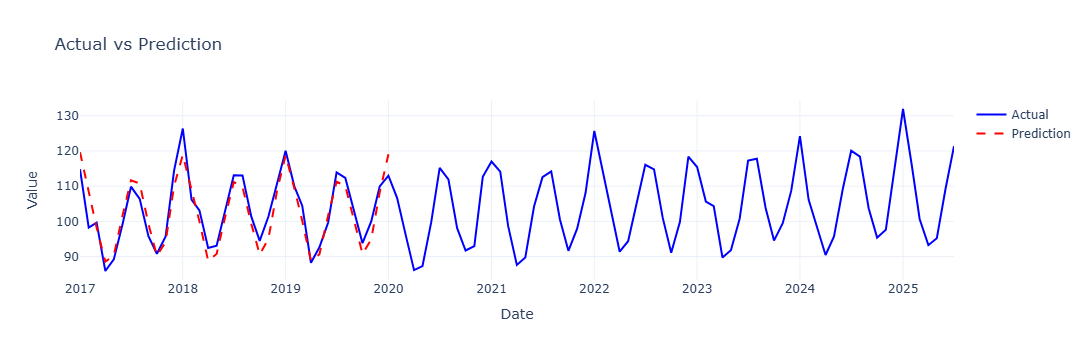

<Figure size 1500x600 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

plt.figure(figsize=(15, 6))

# Create the forecast DataFrame
future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Prediction'])

# Combine the data
combined_data = pd.concat([test, future_forecast], axis=1)

# Create Plotly figure
fig = go.Figure()

# Add actual data
fig.add_trace(go.Scatter(
    x=combined_data.index,
    y=combined_data.iloc[:, 0],  # First column (actual data)
    mode='lines',
    name='Actual',
    line=dict(color='blue')
))

# Add prediction data
fig.add_trace(go.Scatter(
    x=combined_data.index,
    y=combined_data['Prediction'],
    mode='lines',
    name='Prediction',
    line=dict(color='red', dash='dash')
))

# Update layout
fig.update_layout(
    title='Actual vs Prediction',
    xaxis_title='Date',
    yaxis_title='Value',
    template='plotly_white'
)

fig.show()

### Complete SARIMA Model : Observed and predicted values of the period '2017-01-01'- '2020-01-01'

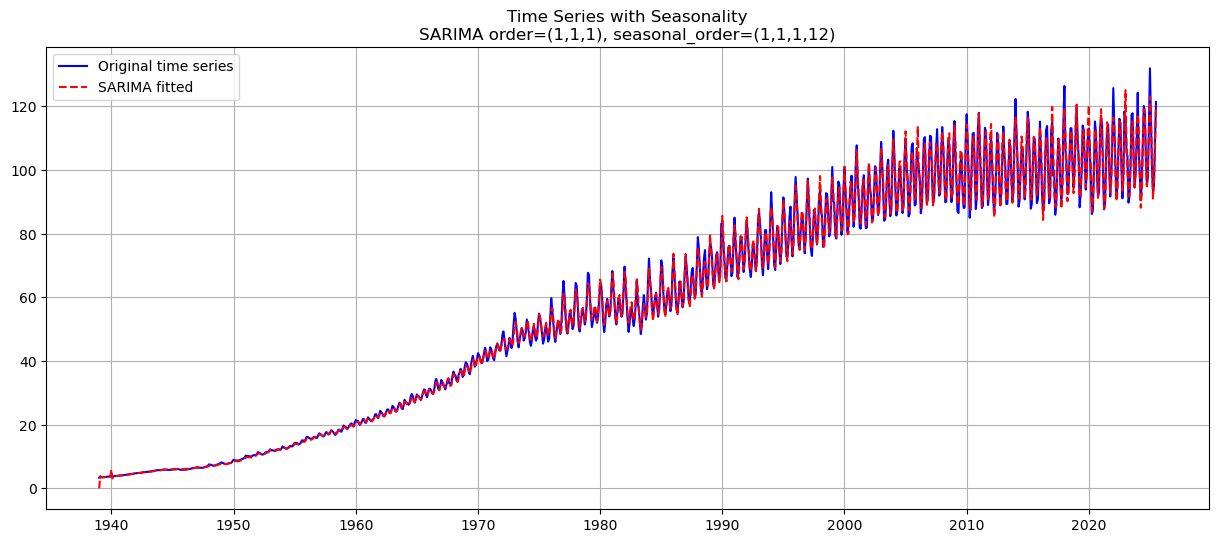

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# SARIMA model
sarima_model = sm.tsa.statespace.SARIMAX(
    data['Energy Production'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit(disp=False)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Energy Production'], label='Original time series', color='blue')
plt.plot(data.index, sarima_results.fittedvalues, label='SARIMA fitted', color='red', linestyle='--')
plt.title("Time Series with Seasonality\nSARIMA order=(1,1,1), seasonal_order=(1,1,1,12)")
plt.legend()
plt.grid(True)
plt.show()

### Filter data from 2010 onwards and their predicted values 

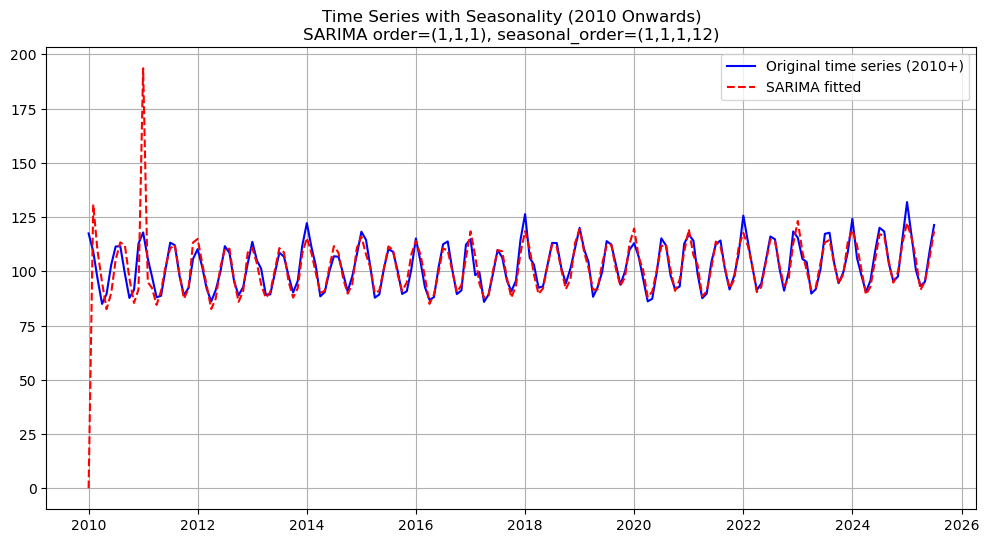

In [36]:

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Filter data from 2010 onwards
data_2010 = data[data.index >= '2010-01-01']

# SARIMA model
sarima_model = sm.tsa.statespace.SARIMAX(
    data_2010['Energy Production'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit(disp=False)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data_2010.index, data_2010['Energy Production'], label='Original time series (2010+)', color='blue')
plt.plot(data_2010.index, sarima_results.fittedvalues, label='SARIMA fitted', color='red', linestyle='--')
plt.title("Time Series with Seasonality (2010 Onwards)\nSARIMA order=(1,1,1), seasonal_order=(1,1,1,12)")
plt.legend()
plt.grid(True)
plt.show()

### Forecasting (future values + confidence intervals) for the next 36 months 

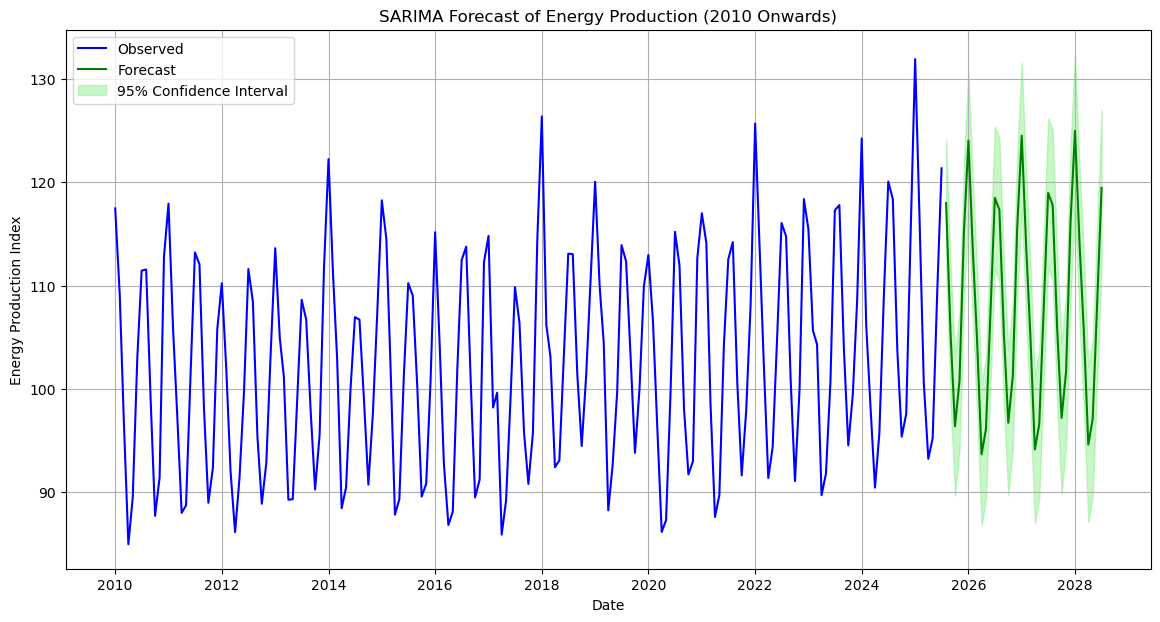

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings


# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Forecast next 36 months
forecast_steps = 36
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data_2010.index[-1] + pd.DateOffset(months=1), 
                               periods=forecast_steps, freq='MS')
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot
plt.figure(figsize=(14, 7))
plt.plot(data_2010.index, data_2010['Energy Production'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                 color='lightgreen', alpha=0.5, label='95% Confidence Interval')
plt.title("SARIMA Forecast of Energy Production (2010 Onwards)")
plt.xlabel("Date")
plt.ylabel("Energy Production Index")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
